In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import shap
import matplotlib.pyplot as plt
import re


In [5]:
data = pd.read_csv('anonymized_resumes.csv')
print(data.head())
print(data.columns)


             id             name                       email  \
0  6b86b273ff34     Allison Hill      schmidtjames@yahoo.com   
1  d4735e3a265e      Noah Rhodes         jessica23@gmail.com   
2  4e07408562be  Angie Henderson  jonathanthompson@gmail.com   
3  4b227777d4dd    Daniel Wagner    thompsonkendra@yahoo.com   
4  ef2d127de37b  Cristian Santos        wwebster@hotmail.com   

                   phone  gender             education  years_experience  \
0  001-854-319-5180x2380    male  BSc Computer Science                 5   
1       644.551.8705x349    male  BSc Computer Science                12   
2       759.273.8320x603    male      MSc Data Science                10   
3     206-541-3836x70241  female      MSc Data Science                 8   
4     865.471.9182x61990  female       BSc Engineering                 5   

                           extra_text              skills  
0                Member of chess club        sql,java,aws  
1               Captain of rugby team 

In [6]:
# 1 = geselecteerd, 0 = niet geselecteerd
data['selected'] = np.where(
    (data['years_experience'] > 3) &
    (data['education'].isin(['Bachelor', 'Master'])),
    1, 0
)


In [8]:
X = data.drop(['id','name','email','phone','selected'], axis=1)
y = data['selected']

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['gender','education']),
        ('text_extra', TfidfVectorizer(max_features=50), 'extra_text'),
        ('text_skills', TfidfVectorizer(max_features=50), 'skills')
    ],
    remainder='passthrough'  # keep years_experience numeric
)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=50, random_state=42))
])

model.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['gender', 'education']),
                                                 ('text_extra',
                                                  TfidfVectorizer(max_features=50),
                                                  'extra_text'),
                                                 ('text_skills',
                                                  TfidfVectorizer(max_features=50),
                                                  'skills')])),
                ('classifier',
                 RandomForestClassifier(n_estimators=50, random_state=42))])

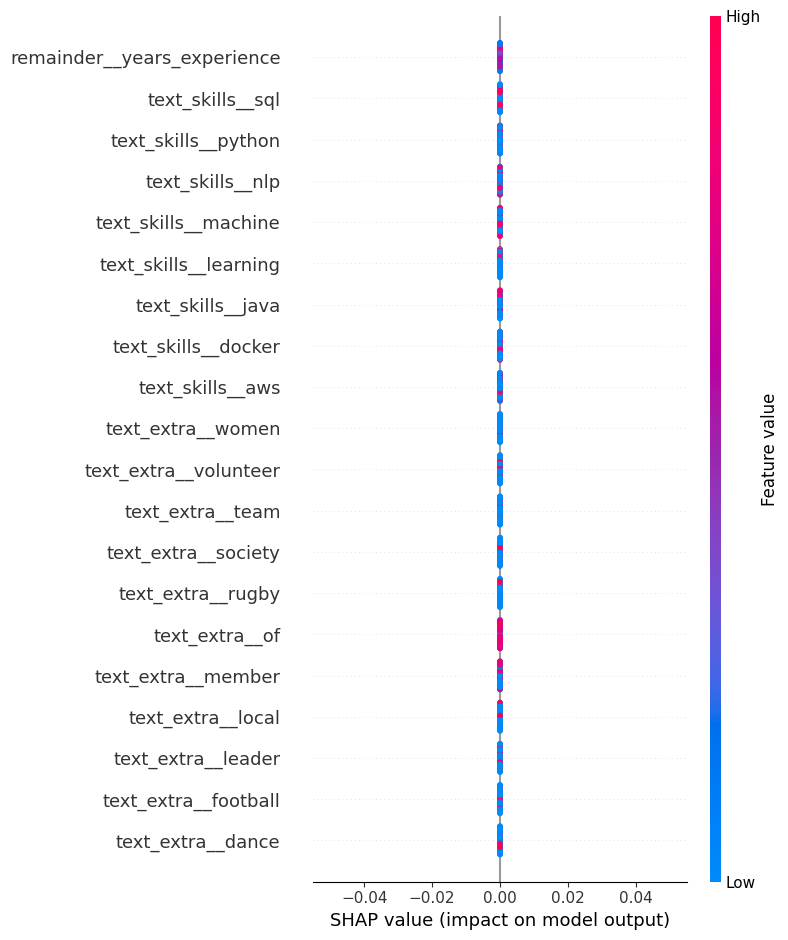

<Figure size 640x480 with 0 Axes>

In [10]:
# SHAP works directly on RandomForest, so we extract the classifier
rf_model = model.named_steps['classifier']
X_test_transformed = model.named_steps['preprocess'].transform(X_test)

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_transformed)

# Globale feature importance
shap.summary_plot(shap_values, X_test_transformed, feature_names=np.array(model.named_steps['preprocess'].get_feature_names_out()))

# Optioneel opslaan
plt.savefig('/content/shap_summary.png')


In [11]:
def detect_pii(df):
    pii_patterns = {
        'email': r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b',
        'phone': r'\b\d{3}[-.\s]?\d{3}[-.\s]?\d{4}\b'
    }
    results = {}
    for col in df.columns:
        results[col] = {}
        for key, pattern in pii_patterns.items():
            matches = df[col].astype(str).str.contains(pattern).sum()
            results[col][key] = matches
    return results

pii_found = detect_pii(data)
print("PII detected:", pii_found)


PII detected: {'id': {'email': np.int64(0), 'phone': np.int64(0)}, 'name': {'email': np.int64(0), 'phone': np.int64(0)}, 'email': {'email': np.int64(400), 'phone': np.int64(0)}, 'phone': {'email': np.int64(0), 'phone': np.int64(117)}, 'gender': {'email': np.int64(0), 'phone': np.int64(0)}, 'education': {'email': np.int64(0), 'phone': np.int64(0)}, 'years_experience': {'email': np.int64(0), 'phone': np.int64(0)}, 'extra_text': {'email': np.int64(0), 'phone': np.int64(0)}, 'skills': {'email': np.int64(0), 'phone': np.int64(0)}, 'selected': {'email': np.int64(0), 'phone': np.int64(0)}}
